# Galaxy vs quasars

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
gal_qso = pd.read_csv("galaxyquasar.csv")

In [3]:
gal_qso

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
X = np.array(gal_qso[["u", "g", "r", "i"]]) - np.array(gal_qso[["g", "r", "i", "z"]])

y = gal_qso['class']
y.replace({'GALAXY': 0, 'QSO': 1}, inplace=True)

labels = ['u - g', 'g - r', 'r - i', 'i - z']

X.shape

(50000, 4)

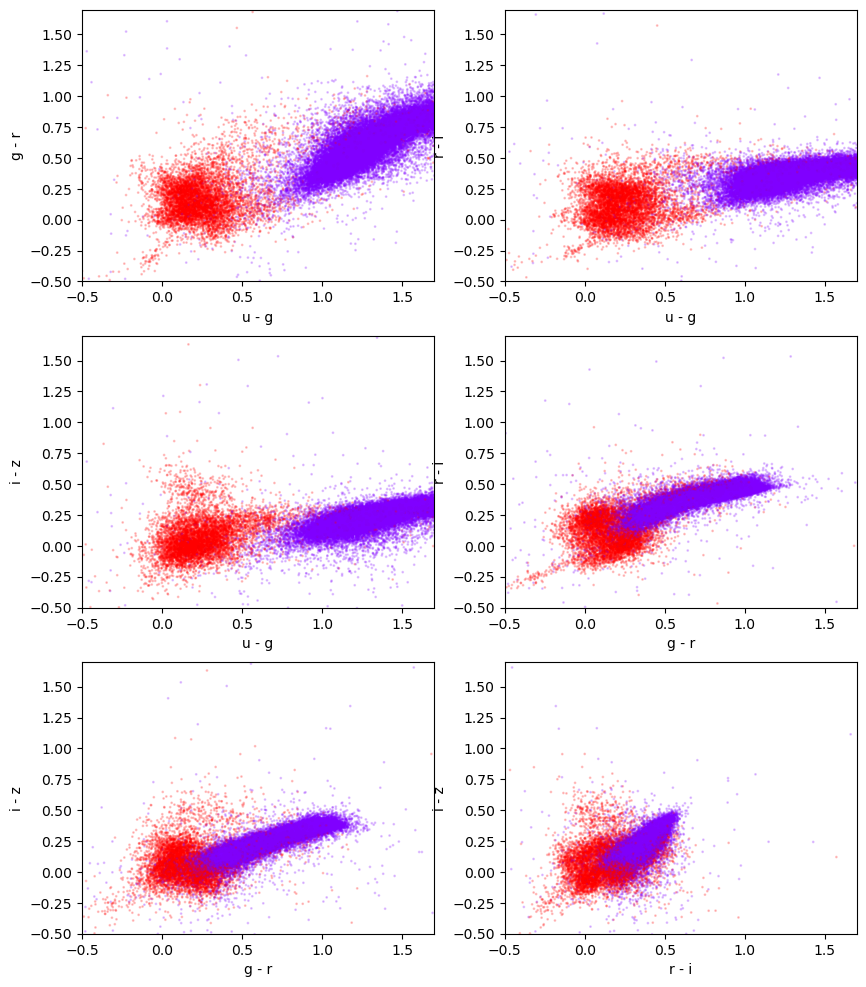

In [5]:
fig = plt.figure(figsize=(10,12))
k = 0
for i in range(0,3):
    for j in range(i+1,4):
        k+=1
        ax = fig.add_subplot(3,2,k)
        ax.scatter(X[:,i], X[:,j], c=[y[j] for j in range(50000)], cmap='rainbow',  s=1, alpha=0.2)
        ax.set_xlabel(labels[i])
        ax.set_ylabel(labels[j])
        ax.set_xlim(-0.5, 1.7)
        ax.set_ylim(-0.5, 1.7)

plt.show()

## Gaussian Naive Bayes

In [6]:
from sklearn.naive_bayes import GaussianNB
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn.metrics import precision_recall_curve, roc_curve

In [7]:
# Split data for training/test

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=70)

### Single feature

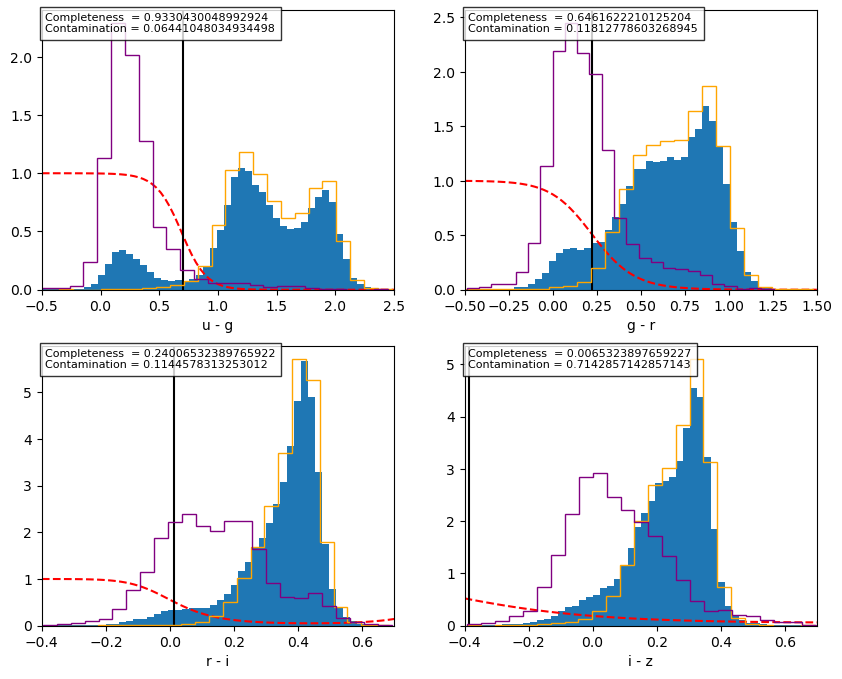

In [8]:
xlim = [[-0.5, 2.5],
        [-0.5, 1.5],
        [-0.4, 0.7],
        [-0.4, 0.7]]

fig = plt.figure(figsize=(10,8))

for i in range(4):
    clf = GaussianNB()
    clf.fit(X_train[:, i:i+1], y_train)
    y_predGNB = clf.predict(X_test[:, i:i+1])
   
    completeness, contamination = completeness_contamination(y_predGNB, y_test)

    xx = np.linspace(xlim[i][0], xlim[i][1], 81)

    Z = clf.predict_proba(np.c_[xx.ravel()])
    Z[:, 1].reshape(xx.shape)
    
    ax = fig.add_subplot(2,2,i+1)
    ax.hist(X[:,i][(X[:,i]>xlim[i][0]) & (X[:,i]<xlim[i][1])], bins=50, density=True)
    ax.plot(xx, 1-Z[:, 0].reshape(xx.shape), 'r--')
    ax.axvline(xx[np.abs(Z[:,0] - 0.5).argmin()], c='k')
    ax.set_xlabel(labels[i])
    ax.set_xlim(xlim[i][0], xlim[i][1])
    
    ax.hist(X[:,i][(X[:,i]>xlim[i][0]) & (X[:,i]<xlim[i][1]) & ([y[j]==0 for j in range(50000)])], 
            bins=25, histtype='step', color='orange', density=True)
    ax.hist(X[:,i][(X[:,i]>xlim[i][0]) & (X[:,i]<xlim[i][1]) & ([y[j]==1 for j in range(50000)])], 
            bins=25, histtype='step', color='purple', density=True)
    
    ax.text(0.01, 0.99, "Completeness  = "+str(completeness)+"\nContamination = "+str(contamination), transform=ax.transAxes, ha='left', va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))


plt.show()

From a single-feature analysis, we see that the data can be classified quite well when considering the u-g and g-r colors, but it becomes much more difficult with the other two colors. This is reasonable, as the histograms of the first two colors show some bimodality, while the histograms of the last two do not. In particular, the first feature (u-g) has the largest completeness and lowest contamination. 

Let's see if we can improve the classification performance by considering more colors.

### Adding other colors

completeness [0.933043   0.92868808 0.92270005 0.92324442]
contamination [0.06441048 0.11099531 0.10695469 0.1134344 ]


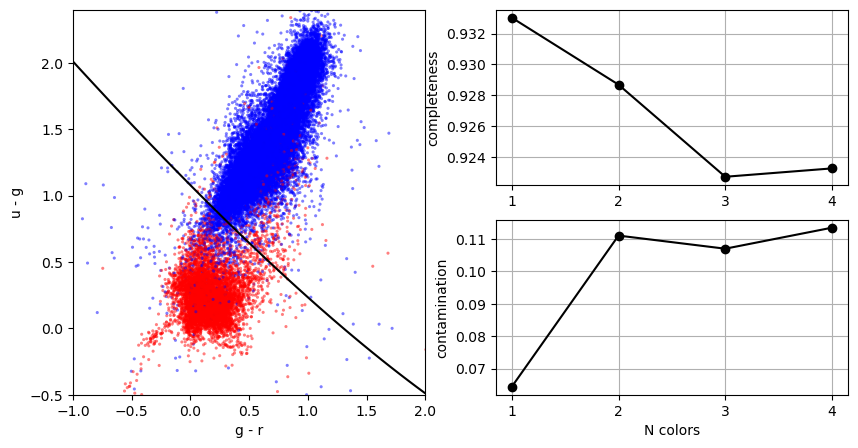

In [9]:
classifiers = []
predictions = []
y_probGNB = []
Ncolors = np.arange(1, len(X[0])+1)

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_predGNB = clf.predict(X_test[:, :nc])
    
    classifiers.append(clf)
    predictions.append(y_predGNB)

completenessGNB, contaminationGNB = completeness_contamination(predictions, y_test)

print("completeness", completenessGNB)
print("contamination", contaminationGNB)

#------------------------------------------------------------
# Compute the decision boundary
clf_ = classifiers[1]
xlim = (-1, 2)
ylim = (-0.5, 2.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81), np.linspace(ylim[0], ylim[1], 71))

Z = clf_.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#---------------------------------------------------------------------------------------------------------
# plot 
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
im = ax.scatter(X[:, 1], X[:, 0], c=y[:], s=5, lw=0, cmap='bwr', alpha=0.5, zorder=2)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(labels[1])
ax.set_ylabel(labels[0])

ax = plt.subplot(222)
ax.plot(Ncolors, completenessGNB, 'o-k', ms=6)
ax.set_ylabel('completeness')
plt.xticks(np.arange(1,5))
ax.grid()

ax = plt.subplot(224)
ax.plot(Ncolors, contaminationGNB, 'o-k', ms=6)
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
plt.xticks(np.arange(1,5))
ax.grid()

plt.show()

The addition of more colors does not improve the classification. Instead, the color u-g alone allows a better classification. As we add colors, the contamination increases and the completeness decreases. Let's plot the ROC-curve for the 4 cases. 

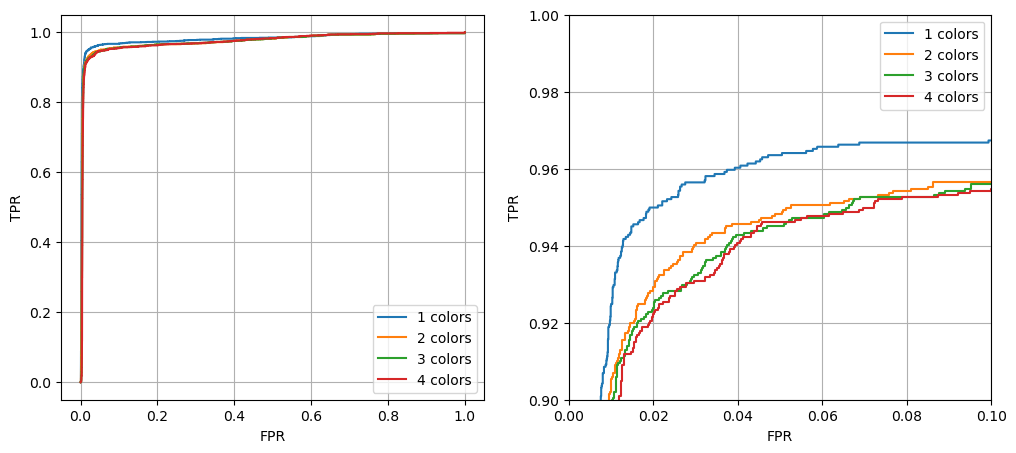

In [10]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_probGNB.append(clf.predict_proba(X_test[:,:nc])[:,1])
    fpr, tpr, thresh = roc_curve(y_test, y_probGNB[-1])
    
    ax1.plot(fpr, tpr, label=str(nc)+' colors')
    
    ax2.plot(fpr, tpr, label=str(nc)+' colors')
    
#plt.title('ROC curve')
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR')
ax1.grid()
ax1.legend()

ax2.set_xlabel('FPR')
ax2.set_ylabel('TPR')
ax2.grid()
ax2.legend()
ax2.set_xlim(0,0.1)
ax2.set_ylim(0.9,1.)

plt.show()

The ROC curve confirms the previous impression: we only need u-g color for classification with Gaussian Naive Bayes. Let's see with other methods.

## Linear Discriminant Analysis

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

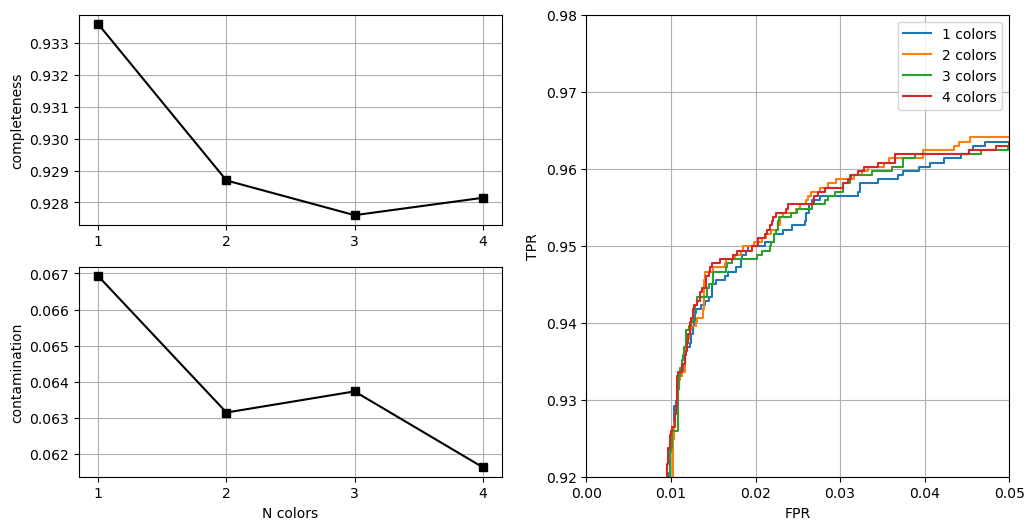

In [12]:
completenessLDA = []
contaminationLDA = []
y_probLDA = []

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(122)

for nc in Ncolors:
    lda = LDA()
    lda.fit(X_train[:, :nc], y_train)
    y_predLDA = lda.predict(X_test[:, :nc])

    completenessLDA.append( completeness_contamination(y_predLDA, y_test)[0] )
    contaminationLDA.append( completeness_contamination(y_predLDA, y_test)[1] )
    
    y_probLDA.append(lda.predict_proba(X_test[:,:nc])[:,1])
    fpr, tpr, thresh = roc_curve(y_test, y_probLDA[-1])
    ax3.plot(fpr, tpr, label=str(nc)+' colors')

# plot completeness and contamination

ax1.plot(Ncolors, completenessLDA, 'sk-')
ax1.grid()
ax1.set_xticks(np.arange(1,5))
ax1.set_ylabel('completeness')

ax2.plot(Ncolors, contaminationLDA, 'sk-')
ax2.grid()
ax2.set_xticks(np.arange(1,5))
ax2.set_xlabel('N colors')
ax2.set_ylabel('contamination')

# plot ROC curve
ax3.set_xlabel('FPR')
ax3.set_ylabel('TPR')
ax3.grid()
ax3.legend()
ax3.set_xlim(0,0.05)
ax3.set_ylim(0.92,0.98)

plt.show()

Now the completeness still decreases with Ncolors, but the contamination decreases too. From the ROC curve we can't clearly distinguish the best number of colors for LDA (in particular between 2 and 4 colors). 

## Quadratic Discriminant Analysis

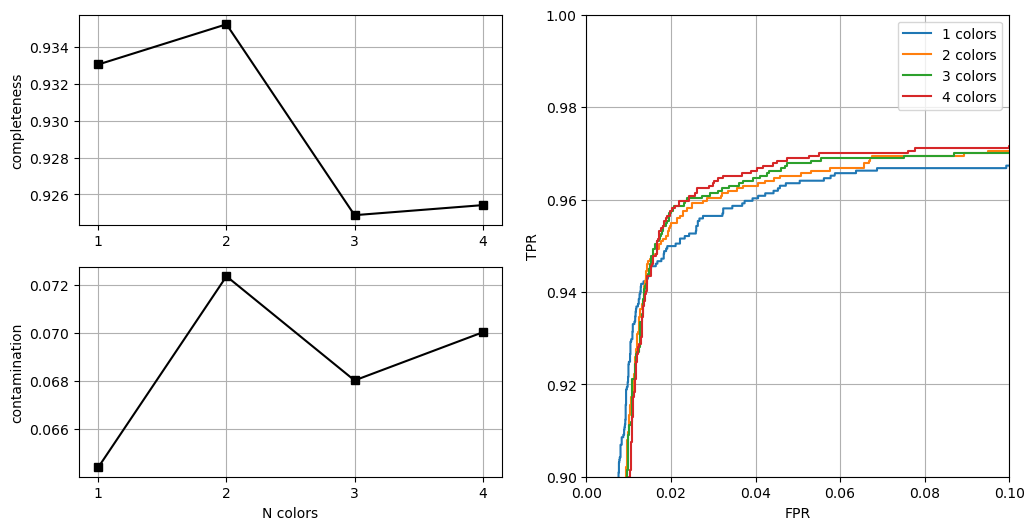

In [13]:
completenessQDA = []
contaminationQDA = []
y_probQDA = []

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(122)

for nc in Ncolors:
    qda = QDA()
    qda.fit(X_train[:, :nc], y_train)
    y_predQDA = qda.predict(X_test[:, :nc])
    
    completenessQDA.append( completeness_contamination(y_predQDA, y_test)[0] )
    contaminationQDA.append( completeness_contamination(y_predQDA, y_test)[1] )

    y_probQDA.append(qda.predict_proba(X_test[:,:nc])[:,1])
    fpr, tpr, thresh = roc_curve(y_test, y_probQDA[-1])
    ax3.plot(fpr, tpr, label=str(nc)+' colors')

# plot completeness and contamination
ax1.plot(Ncolors, completenessQDA, 'sk-')
ax1.grid()
ax1.set_xticks(np.arange(1,5))
ax1.set_ylabel('completeness')

ax2.plot(Ncolors, contaminationQDA, 'sk-')
ax2.grid()
ax2.set_xticks(np.arange(1,5))
ax2.set_xlabel('N colors')
ax2.set_ylabel('contamination')

# plot ROC curve
ax3.set_xlabel('FPR')
ax3.set_ylabel('TPR')
ax3.grid()
ax3.legend()
ax3.set_xlim(0,0.1)
ax3.set_ylim(0.9,1)

plt.show()

## K-Nearest Neighbours

In [14]:
from sklearn.neighbors import KNeighborsClassifier

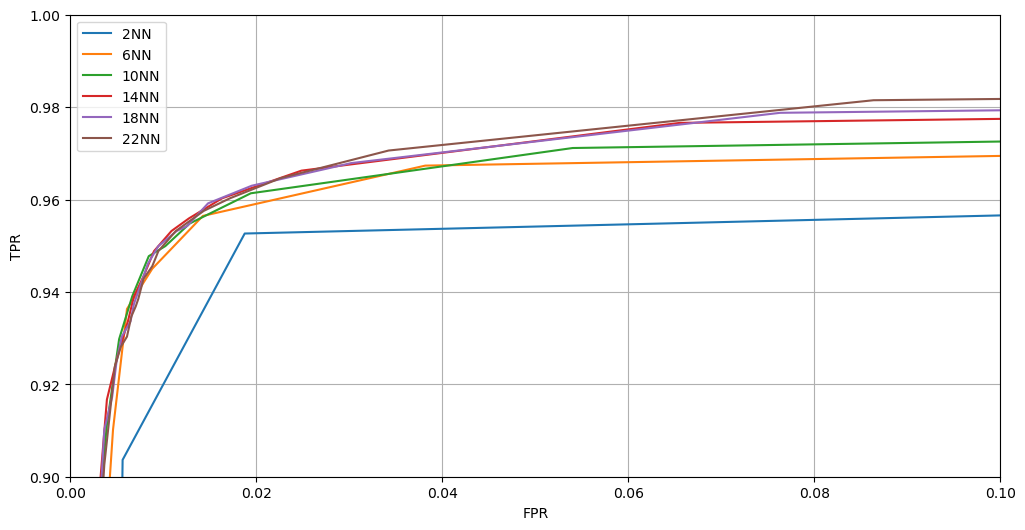

In [15]:
KNN = np.arange(2,23)[::4]

fig = plt.figure(figsize=(12,6))
ax3 = fig.add_subplot(111)

for k in KNN:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train[:,:4],y_train)
    y_predKNN = knn.predict(X_test[:, :4])
    
    completenessKNN, contaminationKNN = completeness_contamination(y_predKNN, y_test)

    y_probKNN = knn.predict_proba(X_test[:,:4]) [:,1] 
    fpr, tpr, thresh = roc_curve(y_test, y_probKNN)
    ax3.plot(fpr, tpr, label=str(k)+'NN')

ax3.set_xlabel('FPR')
ax3.set_ylabel('TPR')
ax3.grid()
ax3.legend()
ax3.set_xlim(0,0.1)
ax3.set_ylim(0.9,1)
plt.show()

From k=14 we have convergence of the ROC curve. Increasing the number of nearest neighbours does not improve the classification. Let's take k=14 and repeat KNN for Ncolors from 1 to 4. 

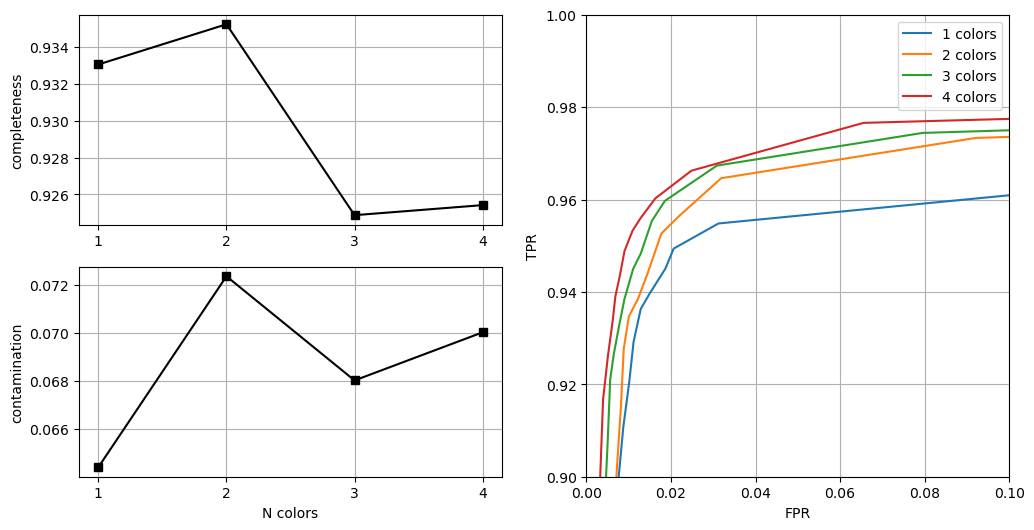

In [16]:
completenessKNN = []
contaminationKNN = []
y_probKNN = []

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(122)

for nc in Ncolors:
    knn = KNeighborsClassifier(n_neighbors=14)
    knn.fit(X_train[:,:nc],y_train)
    y_predKNN = knn.predict(X_test[:, :nc])
    
    completenessKNN.append( completeness_contamination(y_predKNN, y_test)[0] )
    contaminationKNN.append( completeness_contamination(y_predKNN, y_test)[1] )

    y_probKNN.append(knn.predict_proba(X_test[:,:nc]) [:,1] )
    fpr, tpr, thresh = roc_curve(y_test, y_probKNN[-1])
    ax3.plot(fpr, tpr, label=str(nc)+' colors')

# plot completeness and contamination
ax1.plot(Ncolors, completenessQDA, 'sk-')
ax1.grid()
ax1.set_xticks(np.arange(1,5))
ax1.set_ylabel('completeness')

ax2.plot(Ncolors, contaminationQDA, 'sk-')
ax2.grid()
ax2.set_xticks(np.arange(1,5))
ax2.set_xlabel('N colors')
ax2.set_ylabel('contamination')

# plot ROC curve
ax3.set_xlabel('FPR')
ax3.set_ylabel('TPR')
ax3.grid()
ax3.legend()
ax3.set_xlim(0,0.1)
ax3.set_ylim(0.9,1)

plt.show()

## Methods comparison with best Ncolors

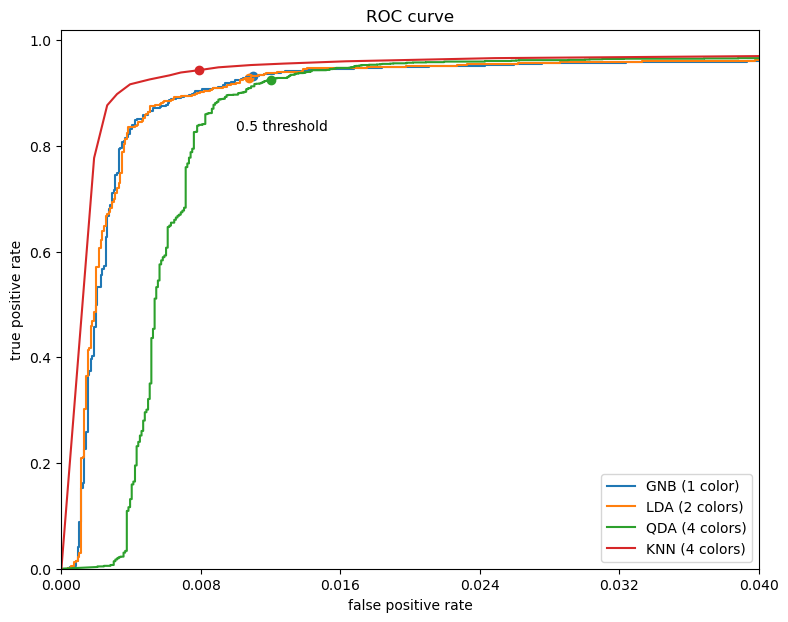

In [33]:
fig = plt.figure(figsize=(9,7))
ax1 = plt.subplot()
A = []

area = 0
fpr, tpr, thresh = roc_curve(y_test, y_probGNB[0])
ax1.plot(fpr, tpr, label='GNB (1 color)')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)
for i in range(1,len(fpr)):
    area += (tpr[i]+tpr[i-1])/2 * (fpr[i]-fpr[i-1])
A.append(area)

area = 0
fpr, tpr, thresh = roc_curve(y_test, y_probLDA[1])
ax1.plot(fpr, tpr, label='LDA (2 colors)')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)
for i in range(1,len(fpr)):
    area += (tpr[i]+tpr[i-1])/2 * (fpr[i]-fpr[i-1])
A.append(area)

area = 0
fpr, tpr, thresh = roc_curve(y_test, y_probQDA[3])
ax1.plot(fpr, tpr, label='QDA (4 colors)')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)
for i in range(1,len(fpr)):
    area += (tpr[i]+tpr[i-1])/2 * (fpr[i]-fpr[i-1])
A.append(area)

area = 0
fpr, tpr, thresh = roc_curve(y_test, y_probKNN[3])
ax1.plot(fpr, tpr, label='KNN (4 colors)')
tx, ty = fpr[np.argmin(abs(thresh-0.5))], tpr[np.argmin(abs(thresh-0.5))]
ax1.scatter(tx,ty)
for i in range(1,len(fpr)):
    area += (tpr[i]+tpr[i-1])/2 * (fpr[i]-fpr[i-1])
A.append(area)

ax1.text(0.01, 0.83, '0.5 threshold')

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('ROC curve')
ax1.legend()

plt.show()

In [37]:
print("Area under the ROC curve:", A)

Area under the ROC curve: [0.9812595572242956, 0.9820223994050215, 0.9807400281326293, 0.9855203951861992]


Best classification method: k-Nearest Neighbours.

### Confusion matrix with kNN (4 colors)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix(y_test, y_predKNN)

array([[10590,    73],
       [  112,  1725]])